https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images.ipynb

In [1]:
import tensorflow as tf
slim = tf.contrib.slim
import sys

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
sys.path.append('/Users/ethen/models/slim')

In [3]:
import os
from nets import inception
from nets.inception import inception_v3
from preprocessing.inception_preprocessing import preprocess_image

In [4]:
session = tf.Session()

In [5]:
image_size = inception_v3.default_image_size
def transform_img_fn(path_list):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f, 'rb').read(), channels = 3)
        image = preprocess_image(image_raw, height = image_size, 
                                 width = image_size, is_training = False)
        out.append(image)
    return session.run([out])[0] # ? pass in a list and index at 0 ??

In [6]:
from datasets import imagenet

# imagenet have a total of 1000 class, but here it will have
# 1001, since there's an additional background class
names = imagenet.create_readable_names_for_imagenet_labels()
len(names)

1001

In [7]:
processed_images = tf.placeholder(tf.float32, shape = (None, image_size, image_size, 3))

In [12]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, _ = inception_v3(processed_images, num_classes=1001, is_training=False)

probabilities = tf.nn.softmax(logits)

# checkpoints_dir = '/Users/marcotcr/phd/tf-models/slim/pretrained'

# method will fail unless you pass a path—and not just a filename—as the 
# second argument. To work around this problem, you can call 
# saver.restore(sess, './model.ckpt') if you are running 
# the script from the directory containing the checkpoint
# http://stackoverflow.com/questions/42053709/unsuccessful-tensorslicereader-constructor-failed-to-find-any-matching-files-fo
init_fn = slim.assign_from_checkpoint_fn(
    # os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
    './inception_v3.ckpt',
    slim.get_model_variables('InceptionV3')
)
init_fn(session)

In [16]:
def predict_fn(images):
    return session.run(probabilities, feed_dict={processed_images: images})

333 Angora, Angora rabbit 0.00176543
285 Siamese cat, Siamese 0.00357689
283 tiger cat 0.0621811
282 tabby, tabby cat 0.137511
286 Egyptian cat 0.759626


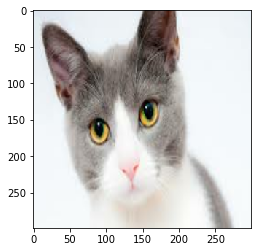

In [17]:
images = transform_img_fn(['cat.jpg'])
# dividing by 2 and adding 0.5 because this is how Inception represents images
preds = predict_fn(images)
for x in preds.argsort()[0][-5:]:
    print(x, names[x], preds[0,x])

plt.imshow(images[0] / 2 + 0.5)
plt.show()

In [19]:
image = images[0]

from time import time
from lime.lime_image import LimeImageExplainer

explainer = LimeImageExplainer()
tmp = time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
print(time() - tmp)

KeyboardInterrupt: 